In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# regla de Sturges para determinar el número de bins en un histograma
def Sturges_rule(n):
    return int(np.ceil(1 + np.log2(n)))
# funcion de espacios para visualización
def espacios(n):
    print("\n"*n)

def mean_non_zero(series):
    return series[series > 0].mean()
# Función para convertir un mes en texto a un número
def mes_a_numero(mes):
    meses = {
        'Enero': 1,
        'Febrero': 2,
        'Marzo': 3,
        'Abril': 4,
        'Mayo': 5,
        'Junio': 6,
        'Julio': 7,
        'Agosto': 8,
        'Septiembre': 9,
        'Octubre': 10,
        'Noviembre': 11,
        'Diciembre': 12,
    }
    return meses[mes]

# Conectar a la base de datos SQLite
conn = sqlite3.connect('sensores.db')

# Leer los datos de la tabla en un DataFrame de pandas
dosificaciones = pd.read_sql_query("SELECT * FROM datos_sensores", conn)
calidad=pd.read_sql_query("SELECT * FROM datos_calidad", conn)
calidad["mes"] = calidad["mes"].apply(mes_a_numero)
calidad.rename(columns={"Conductividad": "Conductividad_tratada"}, inplace=True)

# Cerrar la conexión
conn.close()
# los valores que eran originalmente 0, se convierten en NA para que no lo considere en los cálculos
dosificaciones.replace(0, pd.NA, inplace=True)

# Convertir las columnas 'hora', 'dia', 'mes' y 'año' a un objeto datetime y crear una nueva columna 'datetime'
calidad['FechaHora'] = pd.to_datetime(calidad[['año', 'mes', 'dia', 'hora']].rename(columns={'año': 'year', 'mes': 'month', 'dia': 'day', 'hora': 'hour'}))
calidad.set_index('FechaHora', inplace=True)

dosificaciones['FechaHora'] = pd.to_datetime(dosificaciones[['año', 'mes', 'dia', 'hora']].rename(columns={'año': 'year', 'mes': 'month', 'dia': 'day', 'hora': 'hour'}))
dosificaciones.set_index('FechaHora', inplace=True)

#Extraemos los datos de calidad a partir del 2018
calidad_filtrada = calidad[calidad.index > '2018-01-01']
# Multiplicar la columna de sulfato (columna 5) por 1.33, esto para pasar de ml/L a mg/L
dosificaciones.iloc[:, 5] = dosificaciones.iloc[:, 5] * 1.33

# Creamos un nuevo Dataset sin las columnas de año, mes, día y hora

df_selected = dosificaciones.iloc[:, 4:]

#Las siguientes lineas de codigo tienen la intención de convertir todas las columnas a valores numericos
columnnas = df_selected.columns
for columna in columnnas:
    df_selected[columna]=pd.to_numeric(df_selected[columna], errors='coerce')
del columnnas
columnas = calidad_filtrada.columns
for columna in columnas:
    calidad_filtrada[columna]=pd.to_numeric(calidad_filtrada[columna], errors='coerce')
del columnas


print(df_selected.info())
espacios(2)



calidad=calidad.iloc[:, 4:]
#  Unir los DataFrames con una unión externa
Datos_unificados = pd.merge(calidad, df_selected, how='outer', left_index=True, right_index=True)
Datos_unificados.sort_index(inplace=True)


# Eliminar las filas con valores NA en la columna 'Caudal'
Datos_unificados=Datos_unificados[Datos_unificados["Caudal"].notna()]

columnas_a_eliminar = ['Cloruros_cruda',"Turbiedad_filtrada"]
for columna in columnas_a_eliminar:
    Datos_unificados.drop(columna, axis=1, inplace=True)

print(Datos_unificados.info())
espacios(2)
print(Datos_unificados.describe())



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38204 entries, 2018-01-01 01:00:00 to 2022-06-18 17:00:00
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Caudal    38202 non-null  float64
 1   Sulfato   38201 non-null  float64
 2   Cal       38181 non-null  float64
 3   Cloro1    29665 non-null  float64
 4   Cloro2    38012 non-null  float64
 5   Carbon    9860 non-null   float64
 6   Polimero  38176 non-null  float64
 7   Dioxido   2970 non-null   float64
dtypes: float64(8)
memory usage: 2.6 MB
None



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38202 entries, 2018-01-01 01:00:00 to 2022-06-18 17:00:00
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Color_agua_Natural                    19065 non-null  float64
 1   Alcalinidad_total_cruda               6275 non-null   float64
 2   Du

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23056\2628110368.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calidad_filtrada[columna]=pd.to_numeric(calidad_filtrada[columna], errors='coerce')


In [3]:
#En esta sección creamos las variables adicionales que vamos a analizar para la PTAP
Datos_unificados["Remoción_Turbiedad"]=Datos_unificados["Turbiedad_cruda"]-Datos_unificados["Turbiedad_distribución"]
Datos_unificados["fracción_Turbiedad"]=Datos_unificados["Turbiedad_distribución"]/Datos_unificados["Turbiedad_cruda"]
Datos_unificados["Cloro_Total"]=Datos_unificados["Cloro2"]+Datos_unificados["Cloro1"]
Datos_unificados["Remocion_Manganeso"]=Datos_unificados["Manganeso_cruda"]-Datos_unificados["Manganeso_distribución"]

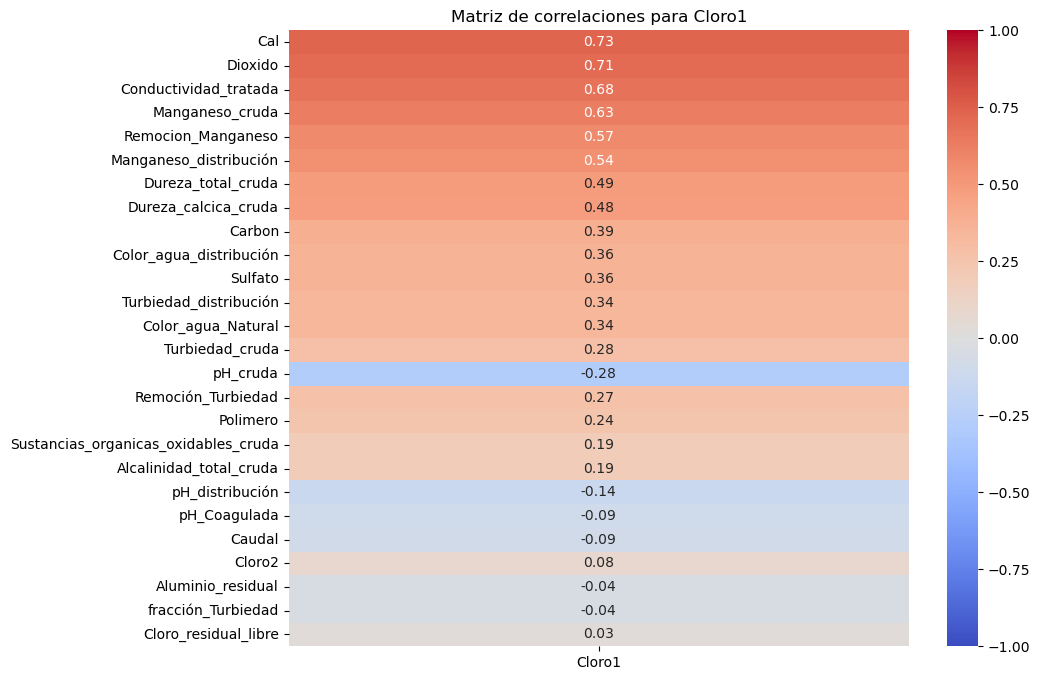

In [4]:
matriz_correlaciones = Datos_unificados.corr()
columnas_dosificaciones=df_selected.columns
def graficar_correlaciones(columna):
    correlaciones = matriz_correlaciones[[columna]].copy()
    # correlaciones.drop(columnas_dosificaciones, inplace=True)
    correlaciones.drop(columna, inplace=True)
    correlaciones['abs_correlacion'] = correlaciones[columna].abs()
    correlaciones.sort_values(by='abs_correlacion', ascending=False, inplace=True)
    correlaciones.drop(columns=['abs_correlacion'], inplace=True)
    correlaciones.drop("Cloro_Total", inplace=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Matriz de correlaciones para {columna}')
    plt.show()
    return correlaciones
correlaciones_cloro1 = graficar_correlaciones('Cloro1')

[]

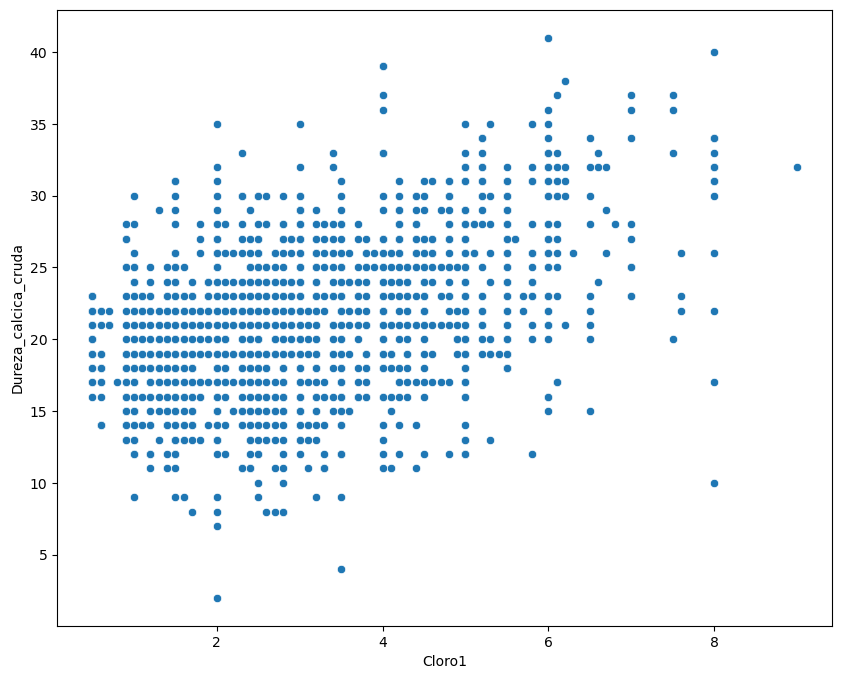

In [5]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=Datos_unificados,
                x='Cloro1',
                y='Dureza_calcica_cruda')
plt.plot()

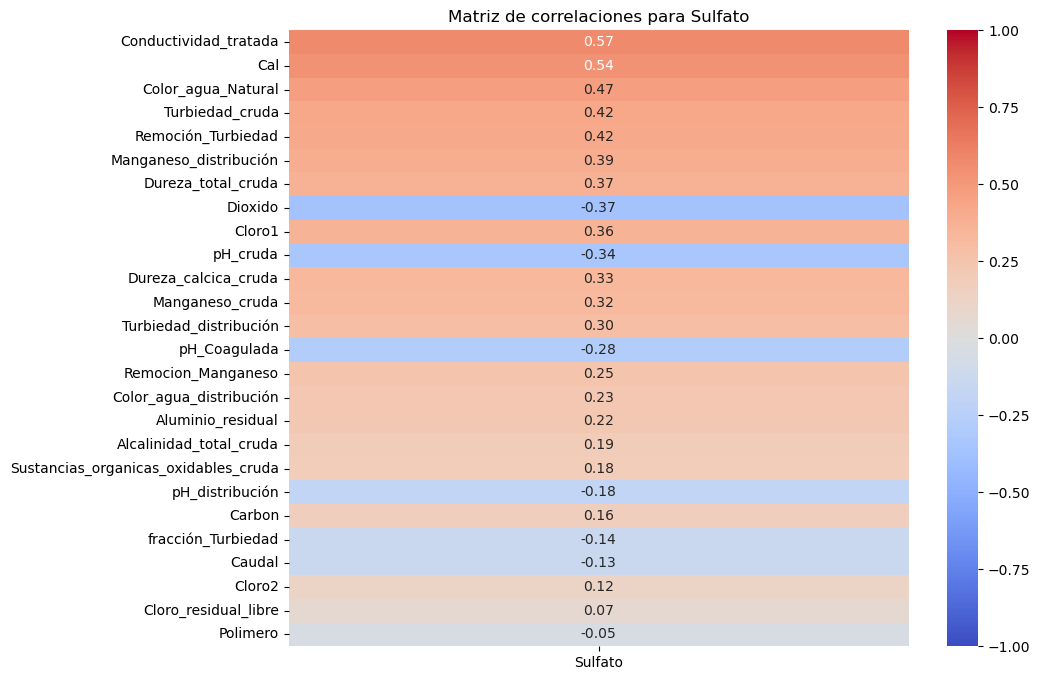

In [6]:
correlaciones_sulfato = graficar_correlaciones('Sulfato')

[]

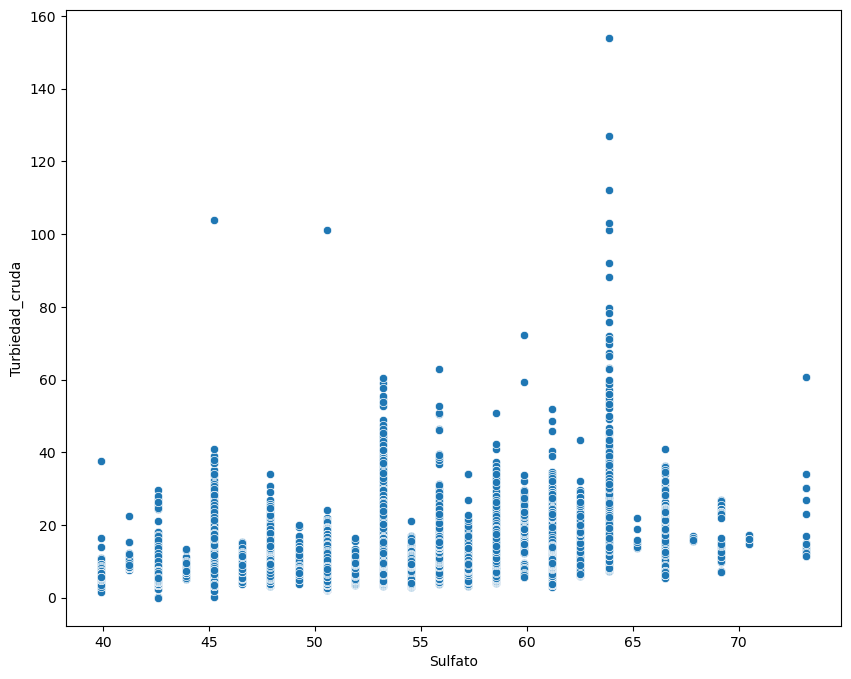

In [7]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=Datos_unificados,
                x='Sulfato',
                y='Turbiedad_cruda')
plt.plot()

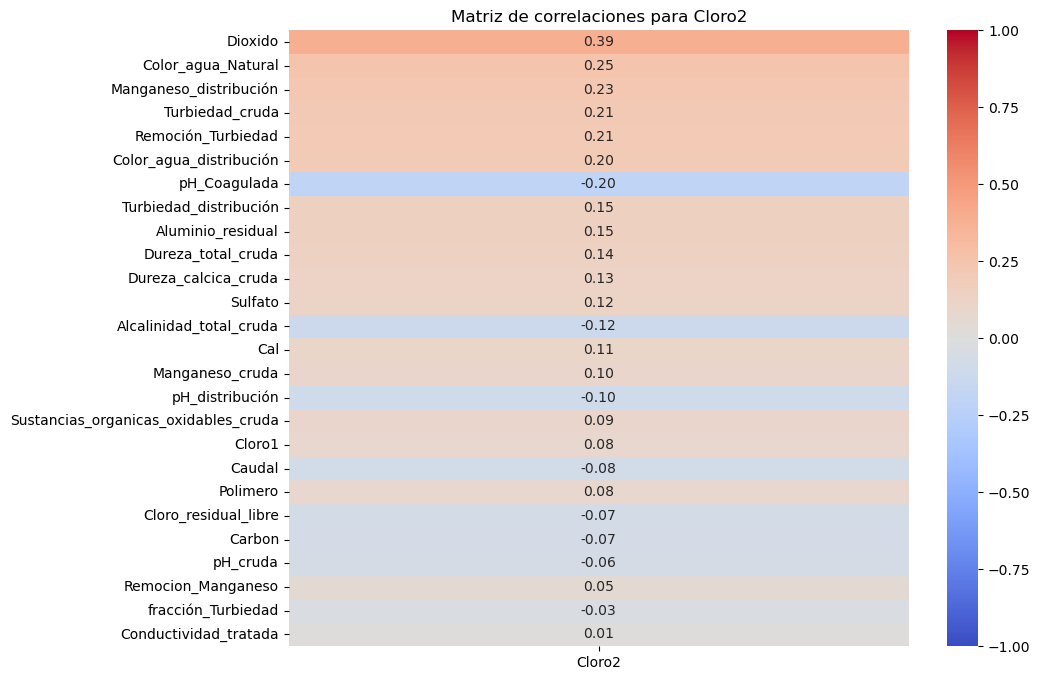

In [8]:
corelaciones_cloro2=graficar_correlaciones('Cloro2')

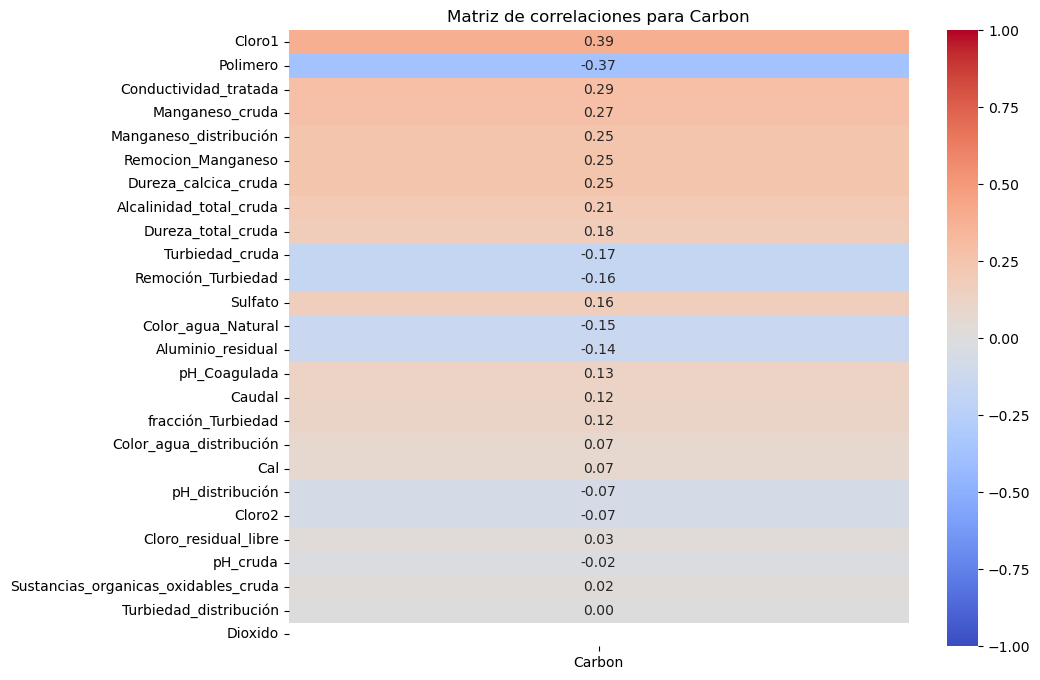

In [9]:
correlaciones_carbon=graficar_correlaciones('Carbon')

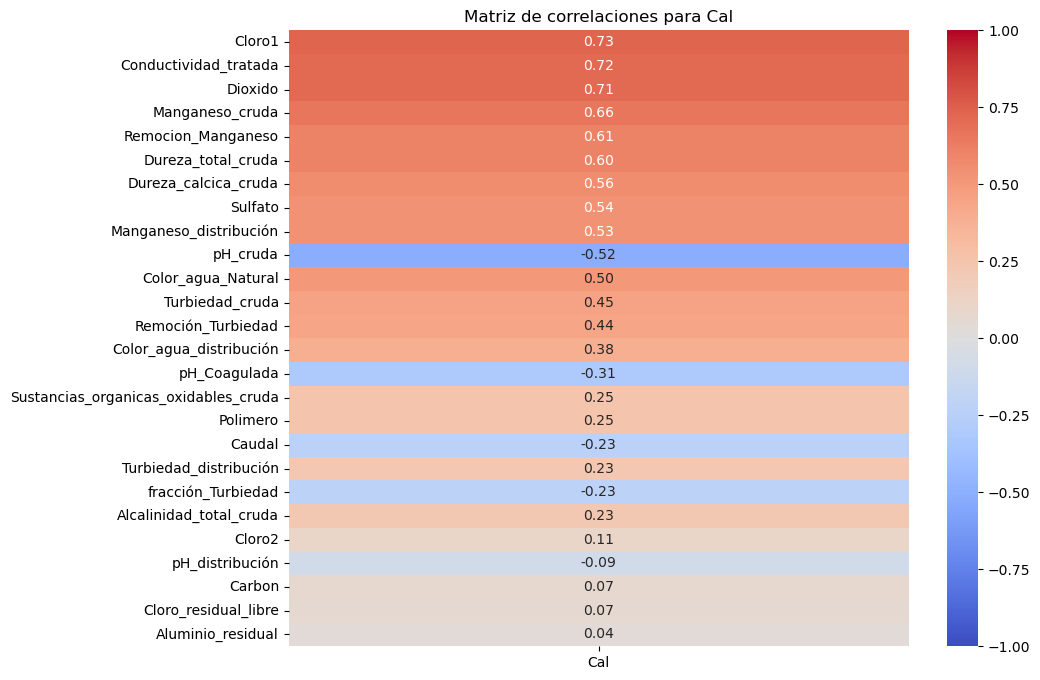

In [10]:
correlaciones_cal=graficar_correlaciones('Cal')

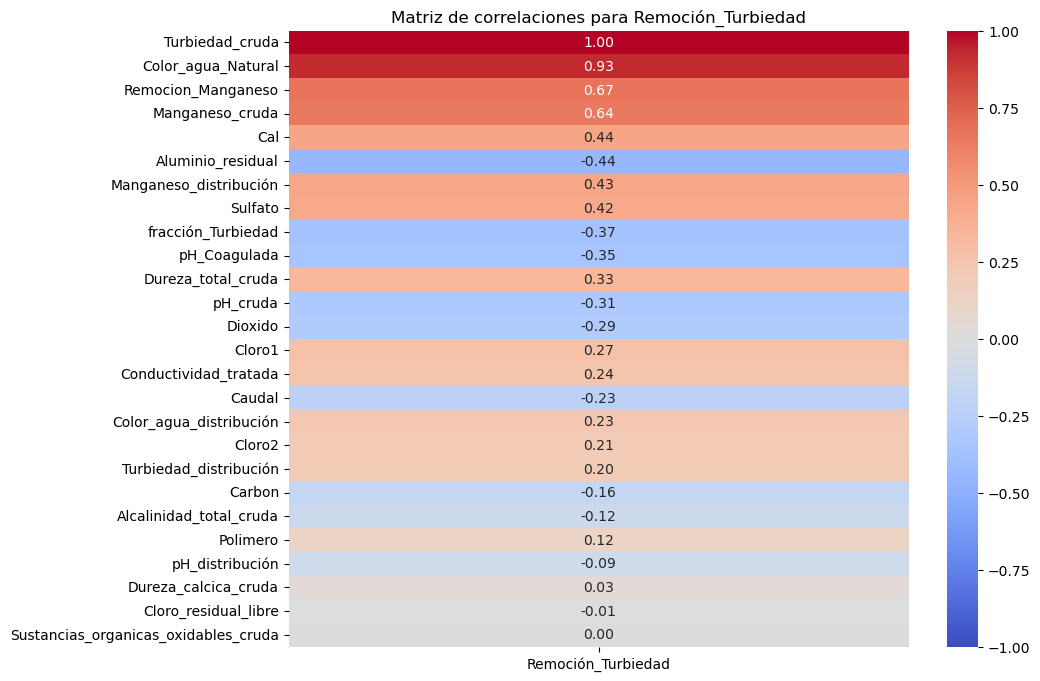

In [11]:
correlaciones_remocion_turbiedad=graficar_correlaciones('Remoción_Turbiedad')


[]

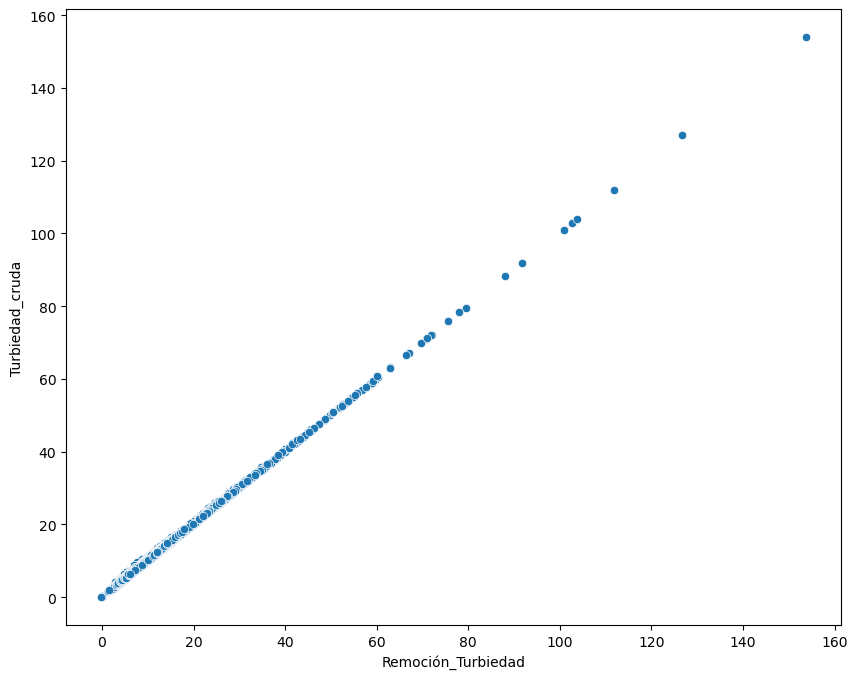

In [12]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=Datos_unificados,
                x='Remoción_Turbiedad',
                y='Turbiedad_cruda')
plt.plot()

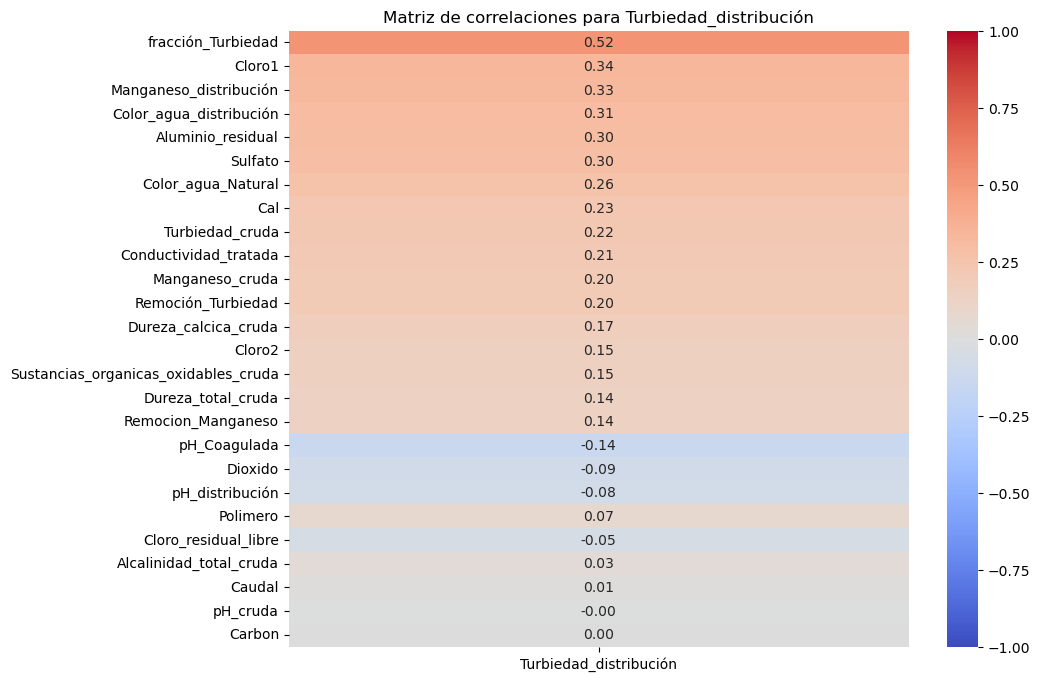

In [13]:
correlaciones_Turbiedad_final=graficar_correlaciones('Turbiedad_distribución')

[]

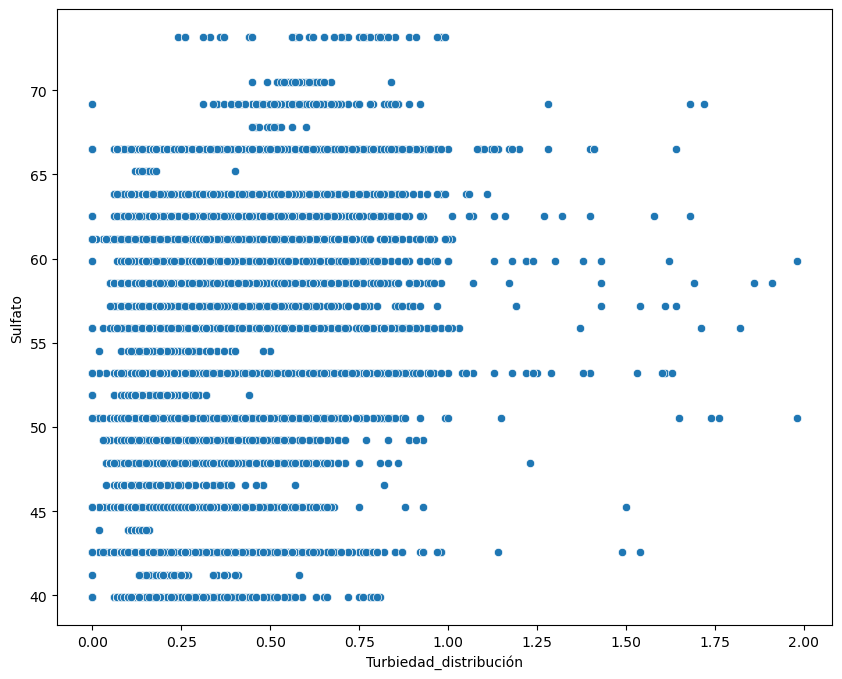

In [14]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=Datos_unificados,
                x='Turbiedad_distribución',
                y='Sulfato')
plt.plot()

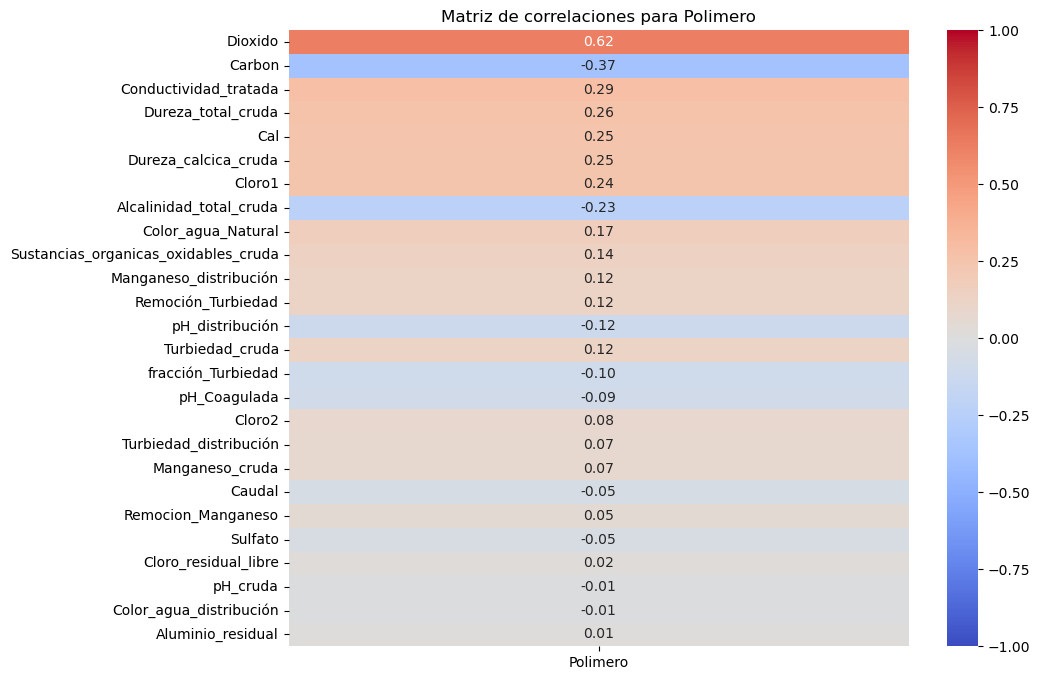

array([0.04 , 0.05 , 0.16 , 0.1  , 0.06 , 0.08 , 0.055, 0.09 , 0.03 ,
       0.025,   nan, 0.075, 0.07 , 0.12 ])

In [15]:
correlaciones_polimeros=graficar_correlaciones('Polimero')
Datos_unificados["Polimero"].unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19051 entries, 2018-01-01 02:00:00 to 2022-06-18 16:00:00
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Color_agua_Natural                    19051 non-null  float64
 1   Alcalinidad_total_cruda               18 non-null     float64
 2   Dureza_calcica_cruda                  4 non-null      float64
 3   Dureza_total_cruda                    6 non-null      float64
 4   Manganeso_cruda                       15 non-null     float64
 5   pH_cruda                              19028 non-null  float64
 6   Sustancias_organicas_oxidables_cruda  10 non-null     float64
 7   Turbiedad_cruda                       19051 non-null  float64
 8   Cloro_residual_libre                  18874 non-null  float64
 9   Color_agua_distribución               19044 non-null  float64
 10  Conductividad_tratada                 8964 non-

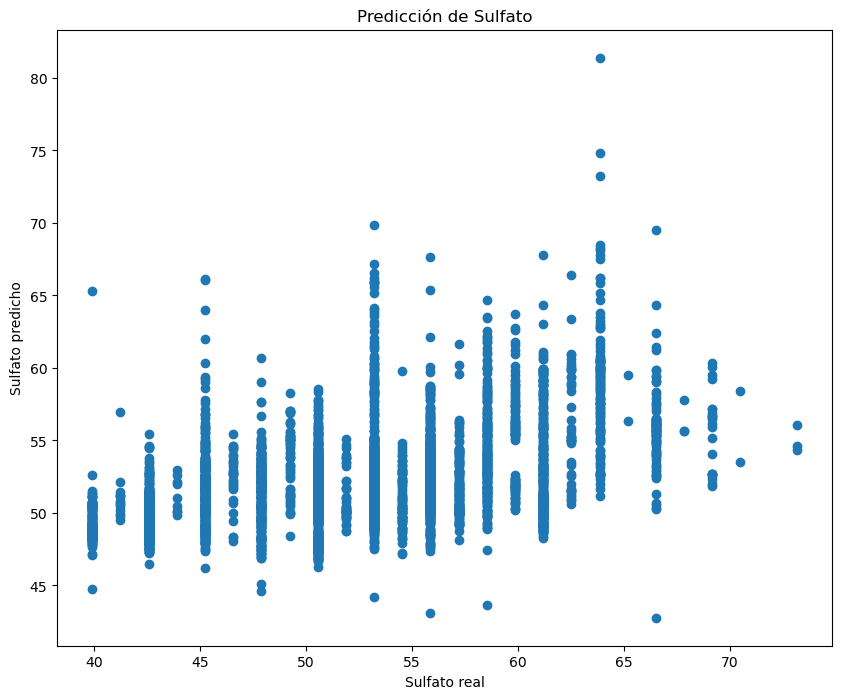

In [16]:
# A partir de esta sección se inicia con el ML de los datos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#se van a seleccionar los datos en donde el valor de sulfato no sea NA
columnas_a_evaluar=[
                    "Turbiedad_cruda",
                    "Color_agua_Natural",
                    # "pH_cruda",
                    "Polimero"
                    ]
columna_objetivo="Sulfato"
# eliminar las filas que tienen datos NA de las columnas a evaluar
datos_filtrados_sulfato = Datos_unificados.copy().dropna(subset=[columna_objetivo])
for columna in columnas_a_evaluar:
    datos_filtrados_sulfato = datos_filtrados_sulfato.dropna(subset=columna)
print(datos_filtrados_sulfato.info())
# x = datos_filtrados_sulfato[['Turbiedad_cruda', 'Color_agua_Natural', 'pH_cruda']]
x=datos_filtrados_sulfato[columnas_a_evaluar]
y = datos_filtrados_sulfato[columna_objetivo]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
modelo_sulfato = LinearRegression()
modelo_sulfato.fit(x_train, y_train)
y_pred = modelo_sulfato.predict(x_test)
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred)
plt.xlabel('Sulfato real')
plt.ylabel('Sulfato predicho')
plt.title('Predicción de Sulfato')
error=mean_squared_error(y_test, y_pred)
print(f"El error cuadratico medio es: {error}")


In [17]:
# Cantidad de datos unicos columna de sulfato
print(Datos_unificados["Sulfato"].nunique())

25


[39.9  41.23 42.56 43.89 45.22 46.55 47.88 49.21 50.54 51.87 53.2  54.53
 55.86 57.19 58.52 59.85 61.18 62.51 63.84 65.17 66.5  67.83 69.16 70.49
 73.15]
       39.90  41.23  42.56  43.89  45.22  46.55  47.88  49.21  50.54  51.87  \
39.90     93      0     22      1     13      0      2      0      0      0   
41.23      0      7      7      0      0      0      0      0      1      0   
42.56     28      8    302      0     27      0     12      0     15      4   
43.89      1      0      1      2      2      2      0      0      0      0   
45.22     17      1     40      3    161      2     29      3     17      2   
46.55      0      0      1      0      5     14      0      4      2      1   
47.88      8      0     17      0     50      5    125      0     21      2   
49.21      0      0      5      0      2      6      2     31      0      1   
50.54      9      0     25      2     25      5     26      1    268      2   
51.87      6      0      8      0      3      1      3  

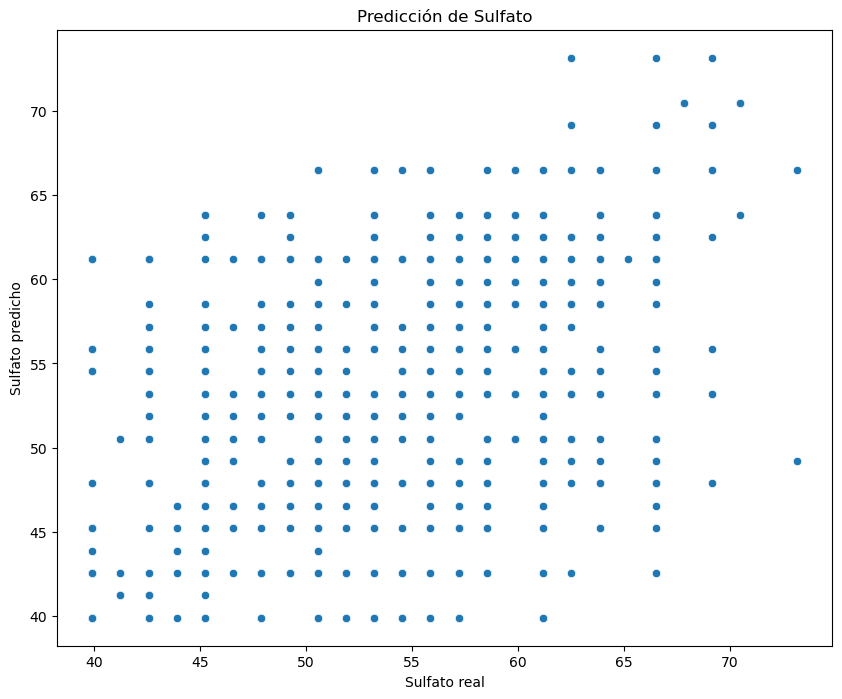

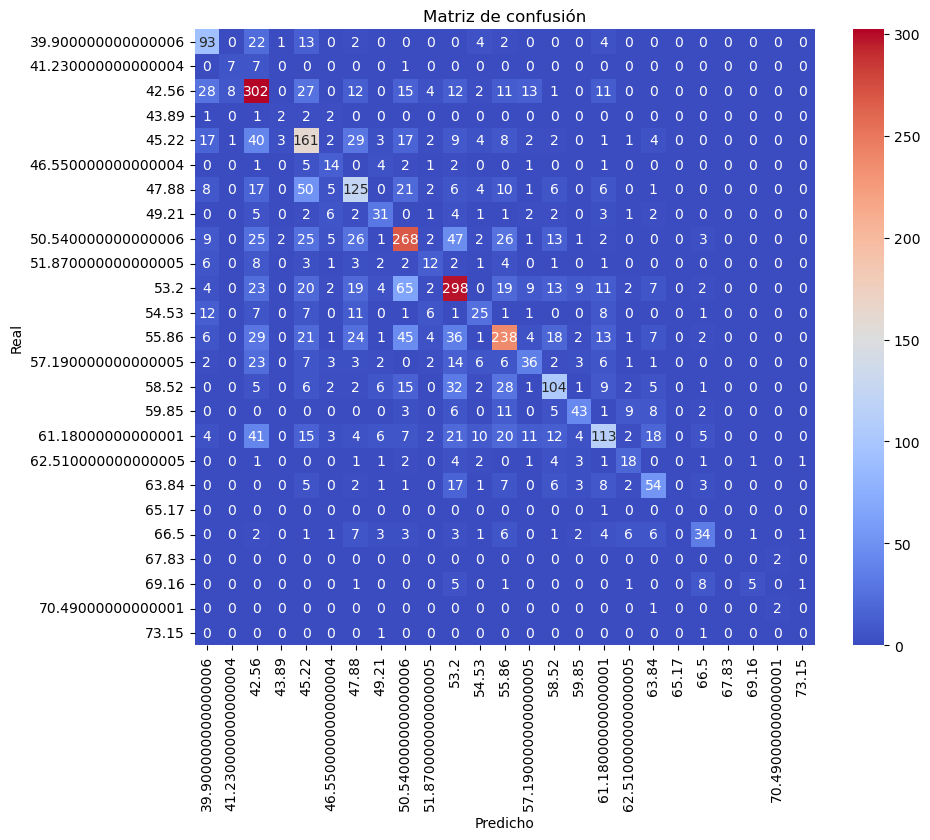

El error cuadratico medio es: 32.564305675249614


In [18]:
# analisis por clustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
columnas_a_evaluar = [
    "Turbiedad_cruda",
    "Color_agua_Natural",
    "pH_cruda",
    "Polimero"
]
columna_objetivo = "Sulfato"
datos_filtrados_sulfato = Datos_unificados.copy().dropna(subset=[columna_objetivo])
for columna in columnas_a_evaluar:
    datos_filtrados_sulfato = datos_filtrados_sulfato.dropna(subset=[columna])
x = datos_filtrados_sulfato[columnas_a_evaluar]
y = datos_filtrados_sulfato[columna_objetivo]
y_unicos=y.unique()
y_unicos.sort()
print(y_unicos)
y = y.apply(lambda x: np.where(y_unicos == x)[0][0])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
clasificador = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
clasificador.fit(x_train_scaled, y_train)
y_pred = clasificador.predict(x_test_scaled)
matriz_confusion = confusion_matrix(y_test, y_pred)
matriz_confusion = pd.DataFrame(matriz_confusion, index=y_unicos, columns=y_unicos)
print(matriz_confusion)
y_pred = y_unicos[y_pred]
y_test = y_unicos[y_test]
matriz_resultado=pd.DataFrame({'Real':y_test,'Predicho':y_pred})
error=mean_squared_error(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Sulfato real')
plt.ylabel('Sulfato predicho')
plt.title('Predicción de Sulfato')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion, annot=True, cmap='coolwarm', fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

print(f"El error cuadratico medio es: {error}")



In [19]:
predicciones_totales=len(y_pred)
print(predicciones_totales)
predicciones_correctas=np.trace(matriz_confusion)
print(predicciones_correctas)
print(predicciones_correctas/predicciones_totales*100)

3806
1985
52.154492905937985


6.054978879856697
53.333333333333336


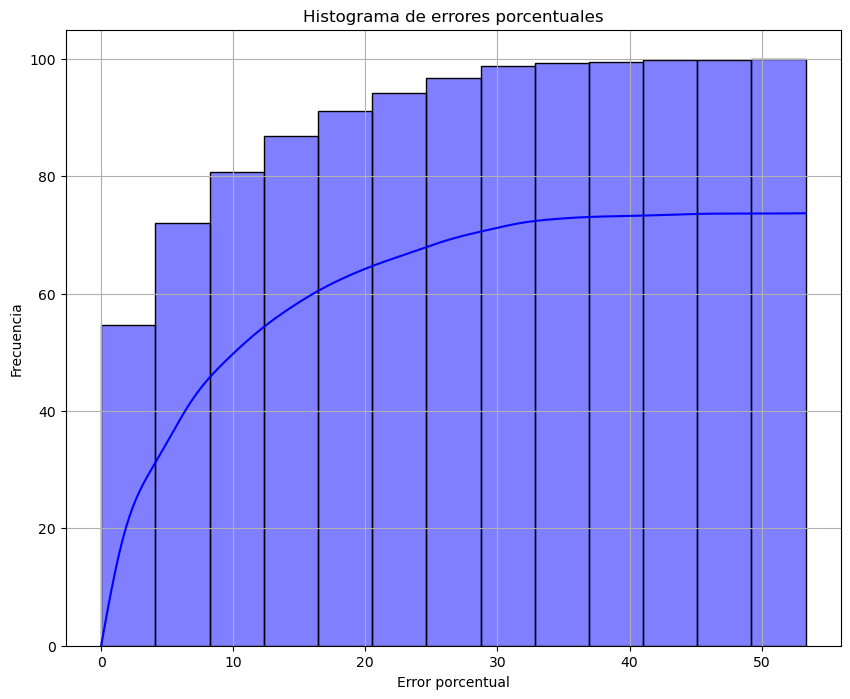

In [27]:
dif=abs(y_test-y_pred)
dif_percent=dif/y_test*100
print(np.mean(dif_percent))
print(np.max(dif_percent))
plt.figure(figsize=(10, 8))
sns.histplot(dif_percent, bins=Sturges_rule(len(dif_percent)), kde=True, color='blue',stat="percent",cumulative=True)
plt.grid()
plt.xlabel('Error porcentual')
plt.ylabel('Frecuencia')
plt.title('Histograma de errores porcentuales')
plt.show()

In [ ]:
# matriz_confusion.to_excel("matriz_confusion.xlsx")